Bidirectional LSTM in encoder, S2S model with attention
Adam, weighted_MSE2

this is the best result

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow import keras

from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential, Model, Sequential
from keras.layers import LSTM, Input, TimeDistributed, RepeatVector, Dense, Bidirectional
from keras.layers import multiply, concatenate, Flatten, Activation, dot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import keras

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae, rmse, r2 = mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# # keras.__version__
# !python --version
# tf.__version__

In [ ]:
idx = pd.IndexSlice
post_PATH = 'C:\\Users\\bobby\\Documents\\GitHub\\attentionMedium\\postprocessed_data\\'
input_data2 = pd.read_csv(post_PATH + 'input_data.csv', index_col=[0], header=[0,1])
input_data2.index = pd.to_datetime(input_data2.index)
input_data2.columns = input_data2.columns.set_levels(input_data2.columns.levels[0].astype('int64'), level=0)
input_data2.columns = input_data2.columns.set_levels(input_data2.columns.levels[1].astype('string'), level=1)

ground_truth2 = pd.read_csv(post_PATH + 'ground_truth.csv', index_col=[0], header=[0,1])
ground_truth2.index = pd.to_datetime(ground_truth2.index)
ground_truth2.columns = ground_truth2.columns.set_levels(ground_truth2.columns.levels[0].astype('int64'), level=0)
ground_truth2.columns = ground_truth2.columns.set_levels(ground_truth2.columns.levels[1].astype('string'), level=1)

log_transform = lambda x: np.log10(x+1) if x.name[1] == 'tp' else x
input_data2 = input_data2.apply(log_transform)
ground_truth2 = ground_truth2.apply(log_transform)

scaledx = MinMaxScaler()
scaled_input = scaledx.fit_transform(input_data2.values)
scaled_input_df = pd.DataFrame(scaled_input, index=input_data2.index, columns=input_data2.columns)
# for output scaling https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re
scaledy = MinMaxScaler()
scaled_ground = scaledy.fit_transform(ground_truth2.values)
scaled_ground_df = pd.DataFrame(scaled_ground, index=ground_truth2.index, columns=ground_truth2.columns)
#-------------------------------------------------------------------------------
frames = [scaled_input_df, scaled_ground_df]
dataset = pd.concat(frames, axis=1)
train_dataset = dataset.loc['2000-01-01':'2016-12-31']
test_dataset = dataset.loc['2017-01-01':'2019-12-31']

In [ ]:
def get_xy(series, time_step, n_feature):
    x = series.iloc[:,:-1].T.unstack(level=0).T.values.reshape(len(series),time_step,n_feature)
    y = pd.concat([series.iloc[:,-1].shift(-i) for i in range(time_step)], axis=1).dropna(axis=0, how='any').values
    y = y.reshape(y.shape[0],y.shape[1],1)
    x = x[:y.shape[0],:,:]
    return x, y
time_step, n_features = 10, 5
train_x, train_y = get_xy(train_dataset, time_step, n_features)
test_x, test_y = get_xy(test_dataset, time_step, n_features)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(6201, 10, 5) (6201, 10, 1)
(1086, 10, 5) (1086, 10, 1)


In [ ]:
# from tensorflow.python.ops.gen_math_ops import square
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer

# Loss function with weights based on amplitude of y_true
import tensorflow as tf
from keras import backend as K

np.random.seed(42)
tf.random.set_seed(42)

def my_MSE_weighted2(y_true,y_pred):
    return K.mean(tf.multiply(tf.exp(tf.multiply(2.0, y_true)), tf.square(tf.subtract(y_pred, y_true))))

input_train = Input(shape=(train_x.shape[1], train_x.shape[2]))
output_train = Input(shape=(train_y.shape[1], train_y.shape[2]))
# print(input_train)
# print(output_train)

In [ ]:
# !pip install tensorflow_addons==0.17.1
# import tensorflow_addons as tfa

# class DecayHistory(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.lr = []
#         self.wd = []

#     def on_batch_end(self, batch, logs={}):
#         self.lr.append(self.model.optimizer.lr(self.model.optimizer.iterations))
#         self.wd.append(self.model.optimizer.weight_decay)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.16.1
    Uninstalling tensorflow-addons-0.16.1:
      Successfully uninstalled tensorflow-addons-0.16.1


In [ ]:
opt = Adam(learning_rate=1e-4)

In [ ]:
def bias2smodel(neurons, activation, loss, opt, input, output):
    model = Sequential()
    # forward_h, forward_c, backward_h, backward_c
    encoder_stack_h, encoder_forward_h, encoder_forward_c, encoder_backward_h, encoder_backward_c = Bidirectional(LSTM(neurons, activation=activation, return_state=True, return_sequences=True))(input)
    encoder_last_h = concatenate([encoder_forward_h, encoder_backward_h])
    encoder_last_c = concatenate([encoder_forward_c, encoder_backward_c])

    decoder_input = RepeatVector(output.shape[1])(encoder_last_h)
    decoder_stack_h = LSTM(neurons*2, activation=activation, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
    attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = Activation('softmax')(attention)
    context = dot([attention, encoder_stack_h], axes=[2,1])
    decoder_combined_context = concatenate([context, decoder_stack_h])

    out = TimeDistributed(Dense(output.shape[2]))(decoder_combined_context)
    model = Model(inputs=input, outputs=out)
    model.compile(loss=loss, optimizer=opt) # adamW mse2
    return model

neurons = 128
activation = 'tanh'

model = bias2smodel(neurons, activation, my_MSE_weighted2, opt, input_train, output_train)
model.fit(train_x, train_y, epochs=160, batch_size=64, verbose=1)

Epoch 1/160
97/97 [==============================] - 18s 121ms/step - loss: 0.0649
Epoch 2/160
97/97 [==============================] - 12s 123ms/step - loss: 0.0465
Epoch 3/160
97/97 [==============================] - 12s 124ms/step - loss: 0.0451
Epoch 4/160
97/97 [==============================] - 12s 123ms/step - loss: 0.0445
Epoch 5/160
97/97 [==============================] - 12s 122ms/step - loss: 0.0441
Epoch 6/160
97/97 [==============================] - 12s 122ms/step - loss: 0.0437
Epoch 7/160
97/97 [==============================] - 13s 134ms/step - loss: 0.0431
Epoch 8/160
97/97 [==============================] - 12s 121ms/step - loss: 0.0431
Epoch 9/160
97/97 [==============================] - 12s 120ms/step - loss: 0.0427
Epoch 10/160
97/97 [==============================] - 12s 120ms/step - loss: 0.0425
Epoch 11/160
97/97 [==============================] - 12s 120ms/step - loss: 0.0421
Epoch 12/160
97/97 [==============================] - 12s 121ms/step - loss: 0.0420
E

In [ ]:
# # attention
# model = Sequential() # 64 best
# neurons = 128
# activation = 'relu'

# encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(neurons, activation=activation, return_state=True, return_sequences=True)(input_train)
# decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
# decoder_stack_h = LSTM(neurons, activation=activation, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
# attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
# attention = Activation('softmax')(attention)
# context = dot([attention, encoder_stack_h], axes=[2,1])
# decoder_combined_context = concatenate([context, decoder_stack_h])

# out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
# model = Model(inputs=input_train, outputs=out)
# model.compile(loss=my_MSE_weighted, optimizer=opt) # adam + mse2

# decay_history = DecayHistory()
# history = model.fit(train_x, train_y, epochs=160, batch_size=64, verbose=1)

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
# ax1.plot(range(0,13580), decay_history.lr)
# ax1.set_title('Learning Rate vs Steps')
# ax2.plot(range(0,13580), decay_history.wd)
# ax2.set_title('Weight Decay vs Steps');

In [ ]:
# # Check input by zhanwei
# plt.plot(history.history['loss'])
# plt.title('epochs VS Loss')
# plt.show()

In [ ]:
pred_e1d1 = model.predict(test_x)

# forecast (leadtime1) vs groundtruth
# t2m	tp	H	C	E
original_test_x = scaledx.inverse_transform(test_x[:,:,[3,4,2,0,1]].reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
original_test_x[:, [1,6,11,16,21,26,31,36,41,46]] = 10**original_test_x[:, [1,6,11,16,21,26,31,36,41,46]] -1 # log scaling back to original tp for test_x

original_test_y = scaledy.inverse_transform(test_y[:,:,0])
original_test_y = 10** original_test_y -1 # log scaling back for test_y

original_test_yhat = scaledy.inverse_transform(pred_e1d1[:,:,0])
original_test_yhat = 10**original_test_yhat - 1 # log scaling for correction
original_test_yhat[original_test_yhat<=0] = 0

original_test_x_tp = original_test_x[:, [1,6,11,16,21,26,31,36,41,46]] # creating a DF for the original_test_x with only tp variable
# original_test_x_tp[:,0]
original_test_y[:,0]  # 1 --> i

# original_test_y[:,i]
# original_test_yhat[:,i])

array([ 2.8000002, 18.3      ,  7.125    , ...,  5.8      ,  8.65     ,
       23.025    ])

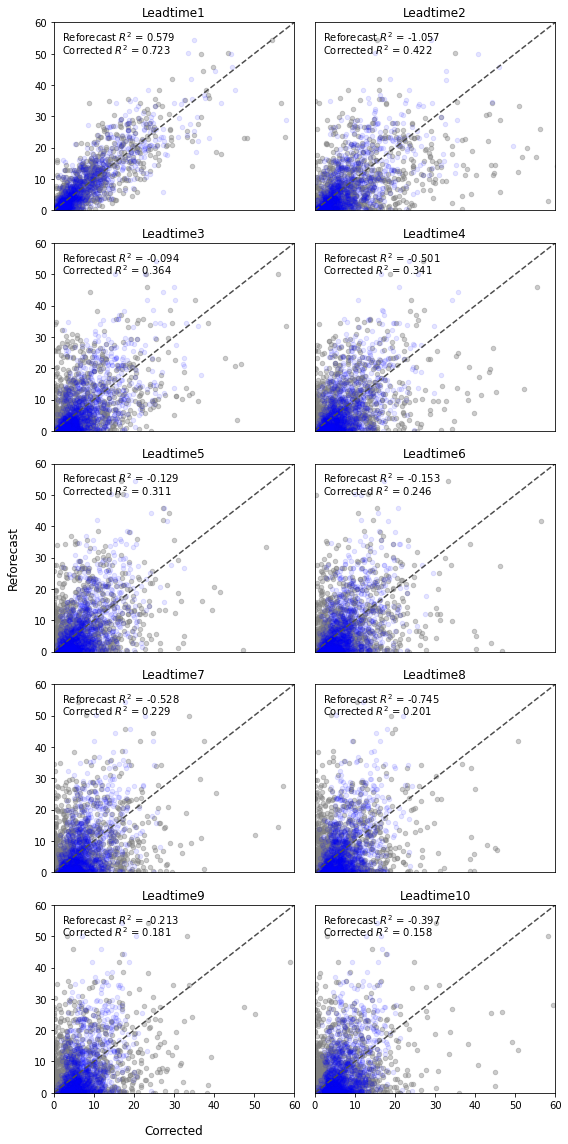

In [ ]:
fig, ax = plt.subplots(5,2,figsize=(8,16))

x = 0
for i in range(5):
  for j in range(2):
    ax[i,j].set_xlim(0,60)
    ax[i,j].set_ylim(0,60)
    ax[i,j].set_title('Leadtime' + str(x+1))

    ax[i,1].get_yaxis().set_visible(False)
    ax[i,j].get_xaxis().set_visible(False)
    #############################################################################
    ax[i,j].plot(ax[i,j].get_xlim(), ax[i,j].get_ylim(), ls="--", c=".3")
    ax[i,j].scatter(original_test_x_tp[:,x], original_test_y[:,x], alpha=0.4, label='GEFS reforecast',s=20,color='grey')
    ax[i,j].scatter(original_test_yhat[:,x], original_test_y[:,x], alpha=0.1, label='Corrected reforecast',s=20, color='blue') # changed to idx0 for test_yhat
    ax[i,j].text(2, 54, r'Reforecast $R^2$ = '+ str(round(r2(original_test_y[:,x], original_test_x_tp[:,x]),3)), fontsize=10)
    ax[i,j].text(2, 50, r'Corrected $R^2$ = '+ str(round(r2(original_test_y[:,x], original_test_yhat[:,x]),3)), fontsize=10)
    x += 1


ax[4,0].get_xaxis().set_visible(True)
ax[4,1].get_xaxis().set_visible(True)
ax[4,0].set_xlabel('Corrected', fontsize=12, labelpad=14)
ax[2,0].set_ylabel('Reforecast', fontsize=12, labelpad=14)
# ax[0,0].text(2, 54, r'Reforecast $R^2$ = '+ str(round(r2(original_test_y[:,0], original_test_x_tp[:,0]),3)), fontsize=10)
# ax[0,0].text(2, 50, r'Corrected $R^2$ = '+ str(round(r2(original_test_y[:,0], original_test_yhat[:,0]),3)), fontsize=10)
fig.tight_layout()
# fig.savefig("testimage.png") #save as jpg
fig.savefig('biadam_mse2.png',dpi=600,bbox_inches = 'tight')

 ### Multiple Scatter Plots for Leadtime 1 - 10

In [ ]:
# # for error plots leadtime 1 to 10
# fig, ax = plt.subplots(2,2,figsize=(10,5))
# fig.subplots_adjust(hspace=0.3)
# ax[0,0].plot([mae(pred_e1d1[:,i,0], test_y[:,i,0]) for i in range(time_step)], label='Corrected reforecast')
# ax[0,0].plot([mae(test_x[:,i,4], test_y[:,i,0]) for i in range(time_step)], label='GEFS reforecast')
# ax[0,0].set_title('Leadtime VS MAE')
# ax[0,0].legend()

# ax[0,1].plot([rmse(pred_e1d1[:,i,0], test_y[:,i,0], squared=False) for i in range(time_step)])
# ax[0,1].plot([rmse(test_x[:,i,4], test_y[:,i,0], squared=False) for i in range(time_step)])
# ax[0,1].set_title('Leadtime VS RMSE')

# ax[1,0].plot([r2(pred_e1d1[:,i,0], test_y[:,i,0]) for i in range(time_step)])
# ax[1,0].plot([r2(test_x[:,i,4], test_y[:,i,0]) for i in range(time_step)])
# ax[1,0].set_title('Leadtime VS R2')

# ax[1,1].axis('off');

In [ ]:
# This part output the assessment result TABLE FOR MAE RMSE AND R2
names = locals()
idx = pd.IndexSlice
result = pd.DataFrame(index=range(1,11),columns=
             pd.MultiIndex.from_product([['mae', 'rmse', 'r2'],
                                         ['original', 'correct']]))

original_test_x_tp = original_test_x[:, [1,6,11,16,21,26,31,36,41,46]] # creating a DF for the original_test_x with only tp variable


for index in ['mae', 'rmse', 'r2']:
    if index != 'rmse':
        result.loc[:,idx[index, 'original']] = [names[index](original_test_y[:,i], original_test_x_tp[:,i])  # 1 --> i
                                                for i in range(time_step)]
        result.loc[:,idx[index, 'correct']] = [names[index](original_test_y[:,i], original_test_yhat[:,i])
                                               for i in range(time_step)]
    else:
        result.loc[:,idx[index, 'original']] = [names[index](original_test_y[:,i], original_test_x_tp[:,i], # 1 --> i
                                                            squared=False)
                                            for i in range(time_step)]
        result.loc[:,idx[index, 'correct']] = [names[index](original_test_y[:,i], original_test_yhat[:,i],
                                                           squared=False)
                                           for i in range(time_step)]
result = result.round(3)
result.to_excel('result_adam_mse2.xlsx')

multiclass confusion matrix

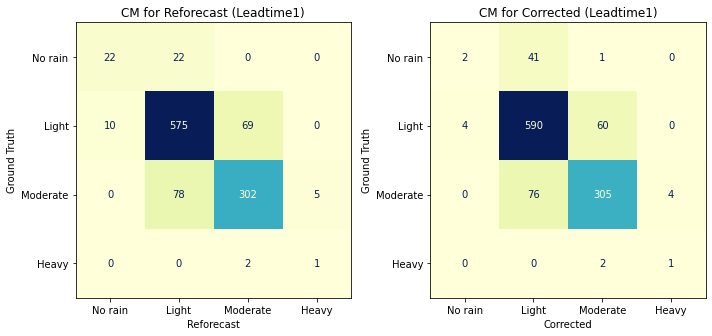

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# corrected tp (predicted tp)
original_test_yhat = scaledy.inverse_transform(pred_e1d1[:,:,0])
original_test_yhat = 10**original_test_yhat - 1 # log scaling correction
original_test_yhat[original_test_yhat<=0] = 0
corrected_df = pd.DataFrame(original_test_yhat)
corrected_df = pd.DataFrame(pd.cut(corrected_df[i], bins=[-1,0,7.5,50,1000],labels=['A','B','C','D']) for i in range(10)).T
# corrected_df = pd.DataFrame(pd.cut(corrected_df[i], bins=[-1,5,20,50,1000],labels=['A','B','C','D']) for i in range(10)).T # indonesia paper

# # reforecast tp
reforecasted_df = pd.DataFrame(original_test_x[:, 1::5])
reforecasted_df = pd.DataFrame(pd.cut(reforecasted_df[i], bins=[-1,0,7.5,50,1000],labels=['A','B','C','D']) for i in range(10)).T
# reforecasted_df = pd.DataFrame(pd.cut(reforecasted_df[i], bins=[-1,5,20,50,1000],labels=['A','B','C','D']) for i in range(10)).T

# # reforecasted_df.loc[reforecasted_df[0] > 64.4] # to check values

# # ground truth test set
original_test_y = scaledy.inverse_transform(test_y[:,:,0])
original_test_y = 10** original_test_y -1 # log scaling back for test_y
real_df = pd.DataFrame(original_test_y)
real_df = pd.DataFrame(pd.cut(real_df[i], bins=[-1,0,7.5,50,1000],labels=['A','B','C','D']) for i in range(10)).T
# real_df = pd.DataFrame(pd.cut(real_df[i], bins=[-1,5,20,50,1000],labels=['A','B','C','D']) for i in range(10)).T

# #-------- plotting of CM (multiclass) --------------------------
cm = confusion_matrix(y_true=real_df.loc[:,0], y_pred=reforecasted_df.loc[:,0])
cm_corrected = confusion_matrix(y_true=real_df.loc[:,0], y_pred=corrected_df.loc[:,0])

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['No rain', 'Light', 'Moderate','Heavy'])
# fig, ax = plt.subplots(figsize=(6,6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
cmd_obj.plot(ax=ax1, colorbar=False, cmap='YlGnBu')
cmd_obj.ax_.set(
                title='CM for Reforecast (Leadtime1)',
                xlabel='Reforecast',
                ylabel='Ground Truth');

cmd_obj_corrected = ConfusionMatrixDisplay(cm_corrected, display_labels=['No rain', 'Light', 'Moderate','Heavy'])
# fig, ax2 = plt.subplots(figsize=(6,6))
cmd_obj_corrected.plot(ax=ax2, colorbar=False, cmap='YlGnBu')
cmd_obj_corrected.ax_.set(
                title='CM for Corrected (Leadtime1)',
                xlabel='Corrected',
                ylabel='Ground Truth');

fig.tight_layout()

In [ ]:
!pip install xlsxwriter
import warnings
warnings.filterwarnings('ignore')
def get_classification_metrics(confusion_matrix):
    # the number of false positives
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix) # axis=0 row
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    return TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC

metrics  = ['TPR', 'TNR', 'PPV', 'NPV', 'FPR', 'FNR', 'FDR', 'ACC']
labels = ['No rain', 'Light', 'Moderate','Heavy']
types = ['original', 'correct']
classification_metrics = pd.DataFrame(index=range(10),
                                      columns = pd.MultiIndex.from_product([metrics, types, labels]))
for i in range(time_step):
    cm = confusion_matrix(y_true=real_df.loc[:,i], y_pred=reforecasted_df.loc[:,i])
    cm_corrected = confusion_matrix(y_true=real_df.loc[:,i], y_pred=corrected_df.loc[:,i])
    TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC = get_classification_metrics(cm)
    for m in metrics:
        classification_metrics.loc[i, idx[m, 'original', :]] = names[m]
    TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC = get_classification_metrics(cm_corrected)
    for m in metrics:
        classification_metrics.loc[i, idx[m, 'correct', :]] = names[m]

# classification_metrics.astype('float').round(3).loc[:,idx['FPR',:,:]].to_excel('Classification.xlsx')
df1 = classification_metrics.astype('float').round(3).loc[:,idx['FPR',:,:]]
df2 = classification_metrics.astype('float').round(3).loc[:,idx['ACC',:,:]]
df3 = classification_metrics.astype('float').round(3).loc[:,idx['TPR',:,:]]
df4 = classification_metrics.astype('float').round(3).loc[:,idx['TNR',:,:]]
df5 = classification_metrics.astype('float').round(3).loc[:,idx['PPV',:,:]]
df6 = classification_metrics.astype('float').round(3).loc[:,idx['FDR',:,:]]

# exporting to excel with different sheets (metrics)
writer = pd.ExcelWriter('Classification_adam_mse2.xlsx', engine = 'xlsxwriter')
df1.to_excel(writer, sheet_name = 'FPR')
df2.to_excel(writer, sheet_name = 'ACC')
df3.to_excel(writer, sheet_name = 'TPR')
df4.to_excel(writer, sheet_name = 'TNR')
df5.to_excel(writer, sheet_name = 'PPV')
df6.to_excel(writer, sheet_name = 'FDR')

writer.save()
writer.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 5.0 MB/s 


errors below

In [ ]:
def mean(lst):
    return sum(lst)/len(lst)

print('mean corrected:', mean([mae(original_test_y[:,i], original_test_yhat[:,i]) for i in range(10)]))
print('mean reforecast:', mean([mae(original_test_y[:,i], original_test_x_tp[:,i]) for i in range(10)]))
# print('train dataset:', mean([mae(train_x[:,i,4], train_y[:,i,0]) for i in range(10)]))

mean corrected: 5.122458863263978
mean reforecast: 6.165236184715009


In [ ]:
# mae
print('reforecast_mae:', [round(mae(original_test_y[:,i], original_test_x_tp[:,i]), 3) for i in range(10)]) # GEFS reforecast (ground truth)
print('corrected_mae:', [round(mae(original_test_y[:,i], original_test_yhat[:,i]), 3) for i in range(10)]) # CORRECTED
# rmse
print('reforecast_rmse:', [round(rmse(original_test_y[:,i], original_test_x_tp[:,i], squared=False), 3) for i in range(10)]) # GEFS reforecast (ground truth)
print('corrected_rmse:', [round(rmse(original_test_y[:,i], original_test_yhat[:,i], squared=False), 3) for i in range(10)]) # CORRECTED
# r2
print('reforecast_r2:', [round(r2(original_test_y[:,i], original_test_x_tp[:,i]), 3) for i in range(10)]) # GEFS reforecast (ground truth)
print('corrected_r2:', [round(r2(original_test_y[:,i], original_test_yhat[:,i]), 3) for i in range(10)]) # CORRECTED

reforecast_mae: [3.226, 6.657, 5.835, 6.356, 6.134, 6.174, 6.906, 6.826, 6.652, 6.885]
corrected_mae: [2.878, 4.654, 4.954, 5.076, 5.21, 5.473, 5.635, 5.701, 5.782, 5.863]
reforecast_rmse: [5.743, 12.69, 9.249, 10.833, 9.4, 9.5, 10.939, 11.688, 9.745, 10.46]
corrected_rmse: [4.66, 6.723, 7.048, 7.178, 7.342, 7.683, 7.77, 7.908, 8.009, 8.119]
reforecast_r2: [0.579, -1.057, -0.094, -0.501, -0.129, -0.153, -0.528, -0.745, -0.213, -0.397]
corrected_r2: [0.723, 0.422, 0.364, 0.341, 0.311, 0.246, 0.229, 0.201, 0.181, 0.158]
